<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-1/04_card_game_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Card game: case study

Our aim is to play a card game in which the cards are iteratively flipped until we tell
the dealer to stop. Then one additional card is flipped. If that card is red, we win a
dollar; otherwise, we lose a dollar.

Our goal is to discover a strategy that best predicts
a red card in the deck.

We will do so by

1. Developing multiple strategies for predicting red cards in a randomly shuffled deck.
2. Applying each strategy across multiple simulations to compute its probability of success within a high confidence interval.
3. Returning the simplest strategy associated with the highest probability of
success.



##Setup

In [ ]:
!wget https://github.com/rahiakela/data-science-research-and-practice/raw/main/data-science-bookcamp/case-study-1/probabilities.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

from probabilities import *

##Predicting red cards in a shuffled deck

We start by creating a deck holding 26 red cards and 26 black cards.

In [ ]:
# Modeling a 52-card deck
red_cards = 26 * [1]
black_cards = 26 * [0]

unshuffled_deck = red_cards + black_cards

In [ ]:
# Shuffling a 52-card deck
np.random.seed(0)

shuffled_deck = np.random.permutation(unshuffled_deck)

How do we decide when we should stop?

One simple strategy is to terminate the
game when the number of red cards remaining in the deck is greater than the number
of black cards remaining in the deck. 

Let’s execute that strategy on the shuffled deck.

In [ ]:
# Coding a card game strategy
remaining_red_cards = 26

for i, card in enumerate(shuffled_deck[:-1]):
  remaining_red_cards -= card
  # Subtracts the total cards seen thus far from 52. This total equals i + 1, since i is initially set to zero
  remaining_total_cards = 52 - i - 1
  if remaining_red_cards / remaining_total_cards > 0.5:
    break

print(f"Stopping the game at index {i}.")
final_card = shuffled_deck[i + 1]
color = "red" if final_card else 0
print(f"The next card in the deck is {'red' if final_card else 'black'}.")
print(f"We have {'won' if final_card else 'lost'}!")

Stopping the game at index 38.
The next card in the deck is red.
We have won!


Our strategy halts when the fraction of
remaining red cards is greater than half of the remaining total cards. 

We can generalize
that fraction to equal a `min_red_fraction` parameter, thus halting when the red card ratio is greater than the inputted parameter value.

In [8]:
# Generalizing the card game strategy
np.random.seed(0)

total_cards = 52
total_red_cards = 26

def execute_strategy(min_fraction_red=0.5, shuffled_deck=None, return_index=False):
  if shuffled_deck is None:
    # Shuffles the unshuffled deck
    shuffled_deck = np.random.permutation(unshuffled_deck)
  
  remaining_red_cards = total_red_cards

  for i, card in enumerate(shuffled_deck[:-1]):
    remaining_red_cards -= card
    # Subtracts the total cards seen thus far from 52. This total equals i + 1, since i is initially set to zero
    fraction_red_cards = remaining_red_cards / (total_cards - i - 1)
    if fraction_red_cards > min_fraction_red:
      break
  # Optionally returns the card index along with the final card
  return (i + 1, shuffled_deck[i + 1]) if return_index else shuffled_deck[i + 1]

###Estimating the probability of strategy success

Let’s apply our basic strategy to a series of 1,000 random shuffles.

The probability of heads slowly converges to 0.5. Thus, the law of large numbers appears to hold up.

###Analyzing biased coin flips

We’ve simulated a sequence of unbiased coin flips, but what if we wish to simulate a coin that falls on heads 70% of the time? 

Well, we can generate that biased output by
calling `np.random.binomial(1, 0.7)`.

The binomial method name refers to the generic
coin-flip distribution, which mathematicians call the binomial distribution. The method
takes as input two parameters: the number of coin flips and the probability of the
desired coin-flip outcome.

In [ ]:
# Simulating biased coin flips
np.random.seed(0)

print("Let's flip the biased coin once.")
coin_flip = np.random.binomial(1, 0.7)
print(f"Biased coin landed on {'heads' if coin_flips == 1 else 'tails'}")

print("\nLet's flip the biased coin 10 times.")
number_coin_flips = 10
head_count = np.random.binomial(number_coin_flips, 0.7)
print(f"{head_count} heads were observed out of {number_coin_flips} biased coin flips")

Let's flip the biased coin once.
Biased coin landed on tails

Let's flip the biased coin 10 times.
6 heads were observed out of 10 biased coin flips


Let’s generate a sequence of 1,000 biased coin flips. We then check if the frequency
converges to 0.7.

In [ ]:
np.random.seed(0)

# Computing coin-flip-frequency convergence
head_count = np.random.binomial(1000, 0.7)
frequency = head_count / 1000
print(f"Frequency of Heads is {frequency}")

Frequency of Heads is 0.697


The frequency of heads approximates 0.7 but is not actually equal to 0.7. In fact, the
frequency value is 0.003 units smaller than the true probability of heads.

Will all the frequencies
be lower than 0.7? 

Will certain frequencies hit the exact value of 0.7? 

We’ll find out by
executing `np.random.binomial(1000, 0.7)` over five looped iterations.

In [ ]:
np.random.seed(0)

# Recomputing coin-flip-frequency convergence
assert np.random.binomial(1000, 0.7) / 1000 == 0.697

for i in range(1, 6):
  head_count = np.random.binomial(1000, 0.7)
  frequency = head_count / 1000
  print(f"Frequency at iteration {i} is {frequency}")
  if frequency == 0.7:
    print("Frequency equals the probability!\n")

Frequency at iteration 1 is 0.69
Frequency at iteration 2 is 0.7
Frequency equals the probability!

Frequency at iteration 3 is 0.707
Frequency at iteration 4 is 0.702
Frequency at iteration 5 is 0.699


The observed frequency appears to fluctuate over every sampling of 1,000 coin
flips. 

It seems that **even though the law of large numbers allows us to approximate the actual probability, some uncertainty still remains**. 

Data science is somewhat messy, and
we cannot always be certain of the conclusions we draw from our data.

Nevertheless, our uncertainty can be measured and contained using what mathematicians call a confidence
interval.

##Computing confidence intervals

Suppose we’re handed a biased coin whose bias we don’t know. We flip the coin 1,000 times and observe a frequency of 0.709. 

We know the frequency approximates the
actual probability, but by how much?

More precisely, what are the chances of the
actual probability falling within an interval close to 0.709 (such as an interval between
0.7 and 0.71)? 

To find out, we must do additional sampling.

The sampling produced some fluctuations in the frequency. 

Let’s explore these fluctuations
by increasing our frequency count from 5 to 500.

In [ ]:
np.random.seed(0)

# Computing frequencies with 500 flips per sample
head_count_list = [np.random.binomial(1000, 0.7) for _ in range(500)]

In [ ]:
np.random.seed(0)

# Optimizing the coin-flip-frequency computation
head_count_array = np.random.binomial(1000, 0.7, size=500)

The output is not a Python list but a NumPy array data structure.

In [ ]:
# Converting a NumPy array to a Python list
assert head_count_array.tolist() == head_count_list

In [ ]:
# Converting a Python list to a NumPy array
new_array = np.array(head_count_list)

assert np.array_equal(new_array, head_count_array) == True

In [ ]:
# Computing frequencies using NumPy
frequency_array = head_count_array / 1000

assert frequency_array.tolist() == [head_count / 1000 for head_count in head_count_list]
assert frequency_array.tolist() == list(map(lambda x: x / 1000, head_count_list))

We’ve converted our head-count array into a frequency array using a simple division
operation. 

Let’s explore the contents of frequency_array in greater detail.



In [ ]:
# Printing a NumPy frequency array
print(frequency_array[:20])

[0.697 0.69  0.7   0.707 0.702 0.699 0.723 0.67  0.702 0.713 0.721 0.689
 0.711 0.697 0.717 0.691 0.731 0.697 0.722 0.728]


The sampled frequencies fluctuate from 0.69 to approximately 0.731.

Let’s extract the minimum and maximum array values.

In [ ]:
# Finding the largest and smallest frequency values
min_freq = frequency_array.min()
max_freq = frequency_array.max()

print(f"Minimum frequency observed: {min_freq}")
print(f"Maximum frequency observed: {max_freq}")
print(f"Difference across frequency range: {max_freq - min_freq}")

Minimum frequency observed: 0.656
Maximum frequency observed: 0.733
Difference across frequency range: 0.07699999999999996


Somewhere in the frequency range of 0.656 to 0.733 lies the true probability of heads.
That interval span is noticeably large, with a more than 7% difference between the
largest and smallest sampled values.

Perhaps we can narrow the frequency range by
plotting all unique frequencies against their occurrence counts.

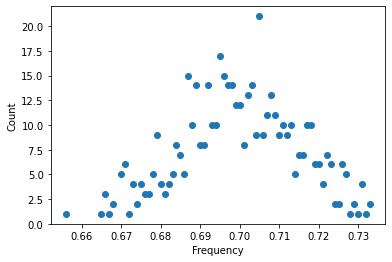

In [ ]:
# Plotting measured frequencies
frequency_counts = defaultdict(int)
for frequency in frequency_array:
  frequency_counts[frequency] += 1

frequencies = list(frequency_counts.keys())
counts = [frequency_counts[freq] for freq in frequencies]

plt.scatter(frequencies, counts)
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

The visualization is informative: frequencies close to 0.7 occur more commonly than other, more distant values.

However, our plot is also flawed, since nearly identical frequencies
appear as overlapping dots in the chart. 

We should group these proximate
frequencies together instead of treating them as individual points.

###Binning similar points

Let’s try a more nuanced visualization by binning together frequencies that are in
close proximity to each other. We subdivide our frequency range into N equally
spaced bins and then place all frequency values into one of those bins.

The bin-based plot we just described is called a `histogram`.

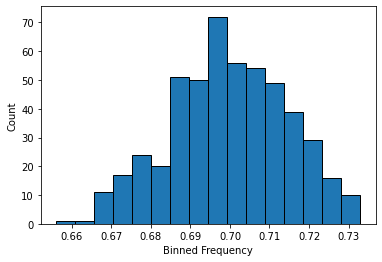

In [ ]:
# Plotting a frequency histogram
plt.hist(frequency_array, bins="auto", edgecolor="black")
plt.xlabel("Binned Frequency")
plt.ylabel("Count")
plt.show()

We can obtain a more precise bin count using counts, which is a NumPy array returned by `plt.hist`.

Number of Bins: 16


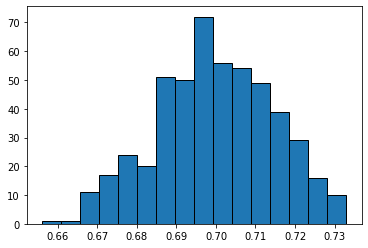

In [ ]:
# Counting bins in a plotted histogram
counts, _, _ = plt.hist(frequency_array, bins="auto", edgecolor="black")
print(f"Number of Bins: {counts.size}")

There are 16 bins in the histogram. 

How wide is each bin?

We can find out by dividing
the total frequency range by 16.

In [ ]:
bin_width = len(frequency_counts.values()) / 16
print(f"Bin width: {bin_width}")

Bin width: 4.3125


Alternatively, we can use the bin_edges array, which is
the second variable returned by plt.hist. This array holds the x-axis positions of the
vertical bin edges in the plot. 

Thus, the difference between any two consecutive edge
positions equals the bin width.

Bin width: 0.004812499999999997


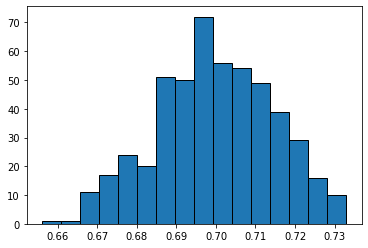

In [ ]:
# Finding the width of bins in a histogram
counts, bin_edges, _ = plt.hist(frequency_array, bins="auto", edgecolor="black")

bin_width = bin_edges[1] - bin_edges[0]
assert bin_width == (max_freq - min_freq) / counts.size
print(f"Bin width: {bin_width}")

The bin_edges array can be used in tandem with counts to output the element count
and coverage range for any specified bin.



In [ ]:
# Getting a bin’s frequency and size
def output_bin_coverage(i):
  # A bin at position i contains counts[i] frequencies
  count = int(counts[i])  
  # A bin at position i covers a frequency range of bin_edges[i] through bin_edges[i+1]
  range_start, range_end = bin_edges[i], bin_edges[i + 1]
  range_string = f"{range_start} - {range_end}"
  print(f"The bin for frequency range {range_string} contains {count} element{'' if count == 1 else 's'}")

In [ ]:
output_bin_coverage(0)

The bin for frequency range 0.656 - 0.6608125 contains 1 element


In [ ]:
output_bin_coverage(5)

The bin for frequency range 0.6800625 - 0.684875 contains 20 elements


In [ ]:
output_bin_coverage(10)

The bin for frequency range 0.704125 - 0.7089375 contains 54 elements


Now, let’s compute the count and frequency range for the highest peak in our histogram.

In [ ]:
# Finding the index of an array’s maximum value
assert counts[counts.argmax()] == counts.max()

Thus, calling `output_bin_coverage(counts.argmax())` should provide us with the output we’ve requested.

In [ ]:
output_bin_coverage(counts.argmax())

The bin for frequency range 0.6945 - 0.6993125 contains 72 elements


###Deriving probabilities from histograms

How can we determine whether the
actual probability of heads falls within that range (without knowing the answer in
advance)?

One option is to calculate the likelihood that a randomly measured frequency
falls within 0.694 to 0.699. If that likelihood were 1.0, then 100% of measured
frequencies would be covered by the range.

How should we calculate the likelihood?

Earlier, we showed that the likelihood of
an interval equals its area under a curve, but only when the total plotted area sums
to 1.0.



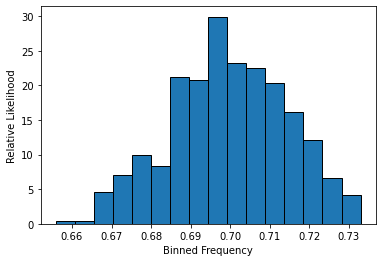

In [ ]:
# Plotting a histogram’s relative likelihoods
likelihoods, bin_edges, _ = plt.hist(frequency_array, bins="auto", edgecolor="black", density=True)
plt.xlabel("Binned Frequency")
plt.ylabel("Relative Likelihood")
plt.show()

Of course, the area beneath our histogram
now sums to 1.0. 

We can prove this by summing the rectangular area of each bin,
which equals the bin’s vertical likelihood value multiplied by `bin_width`.

In [ ]:
assert likelihoods.sum() * bin_width == 1.0

The histogram’s total area sums to 1.0. Thus, the area beneath the histogram’s peak
now equals the probability of a randomly sampled frequency falling within the 0.694
to 0.699 interval range.

Let’s compute this value by calculating the area of the bin
positioned at `likelihoods.argmax()`.

In [ ]:
# Computing the probability of the peak frequencies
index = likelihoods.argmax()
area = likelihoods[index] * bin_width
range_start, range_end = bin_edges[index], bin_edges[index + 1]
range_string = f"{range_start} - {range_end}"
print(f"Sampled frequency falls within interval {range_string} with probability {area}")

Sampled frequency falls within interval 0.6945 - 0.6993125 with probability 0.144


The probability is approximately 14%. That value is low, but we can increase it by
expanding our interval range beyond one bin.

In [ ]:
# Increasing the probability of a frequency range
peak_index = likelihoods.argmax()
start_index, end_index = (peak_index - 1, peak_index + 2) 
area = likelihoods[start_index: end_index + 1].sum() * bin_width
range_start, range_end = bin_edges[start_index], bin_edges[end_index + 1]
range_string = f"{range_start} - {range_end}"
print(f"Sampled frequency falls within interval {range_string} with probability {area}")

Sampled frequency falls within interval 0.6896875 - 0.7089375 with probability 0.464


Thus, the three bins represent what statisticians call a 46.4%
confidence interval, which means we are 46.4% confident that our true probability falls
within the three-bin range.

That confidence percentage is too low. 

Statisticians prefer a
confidence interval of 95% or more. 

We reach that confidence interval by iteratively
expanding our leftmost bin and rightmost bin until the interval area stretches past 0.95.

In [ ]:
# Computing a high confidence interval
def compute_high_confidence_interval(likelihoods, bin_width):
  peak_index = likelihoods.argmax()
  area = likelihoods[peak_index] * bin_width
  start_index, end_index = peak_index, peak_index + 1

  while area < 0.95:
    if start_index > 0:
      start_index -= 1
    if end_index < likelihoods.size - 1:
      end_index += 1
    area = likelihoods[start_index: end_index + 1].sum() * bin_width

  range_start, range_end = bin_edges[start_index], bin_edges[end_index]
  range_string = f"{range_start:.6f} - {range_end:.6f}"
  print(f"The frequency range {range_string} represents a {100 * area:.2f}% confidence interval")

  return start_index, end_index

In [ ]:
compute_high_confidence_interval(likelihoods, bin_width)

The frequency range 0.670438 - 0.723375 represents a 95.40% confidence interval


(3, 14)

The frequency range of roughly 0.670 to 0.723 represents a 95.4% confidence interval.
Thus, a sampled sequence of 1,000 biased coin flips should fall within that range
95.4% of the time.

We’re fairly confident that the true probability lies somewhere
between 0.670 and 0.723. 

However, we still cannot tell for sure whether the true probability
is closer to 0.67 or 0.72. 

We need to somehow narrow that range to obtain a
more informative probability estimation.

###Shrinking the range of a high confidence interval

How can we taper down our range while maintaining a 95% confidence interval? 

Perhaps we should try elevating the frequency count from 500 to something noticeably larger.

Instead, let’s sample 100,000 frequencies while keeping the
coin-flip count constant at 1,000.

In [ ]:
np.random.seed(0)

head_count_array = np.random.binomial(1000, 0.7, 100000)
frequency_array = head_count_array / 1000
assert head_count_array.size == 100000

Let’s incorporate the confidence interval into our
visualization by coloring the histogram bars in its range.

The histogram bars can be visually modified by relying on `patches`, which is the third variable
returned by `plt.hist`.

The frequency range 0.670429 - 0.727857 represents a 95.42% confidence interval


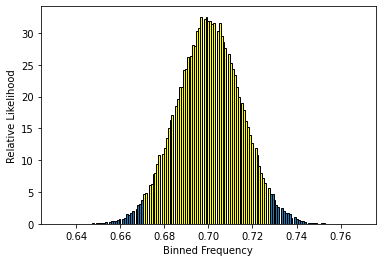

In [ ]:
likelihoods, bin_edges, patches = plt.hist(frequency_array, bins="auto", edgecolor="black", density=True)

bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)

for i in range(start_index, end_index):
  patches[i].set_facecolor("yellow")

plt.xlabel("Binned Frequency")
plt.ylabel("Relative Likelihood")
plt.show()

The recomputed histogram resembles a symmetric bell-shaped curve.

The highlighted bars represent
a 95% confidence interval. The interval covers a frequency range of roughly 0.670 to 0.727.

Perhaps we should
also increase the number of coin flips per frequency sample from 1,000 to 50,000.

We keep the frequency sample size steady at 100,000, thus leading to 5 billion
flipped coins.

The frequency range 0.695769 - 0.703708 represents a 95.06% confidence interval


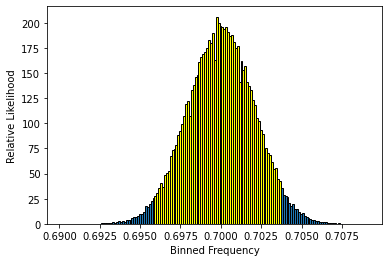

In [ ]:
np.random.seed(0)

head_count_array = np.random.binomial(50000, 0.7, 100000)
frequency_array = head_count_array / 50000

likelihoods, bin_edges, patches = plt.hist(frequency_array, bins="auto", edgecolor="black", density=True)

bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)

for i in range(start_index, end_index):
  patches[i].set_facecolor("yellow")

plt.xlabel("Binned Frequency")
plt.ylabel("Relative Likelihood")
plt.show()

We are thus
exceedingly confident that our true probability is approximately 0.70.

On a separate note, our updated histogram once again resembles a bell-shaped
curve. That curve is referred to as either the Gaussian distribution or the normal distribution.

The normal distribution is incredibly important to probability theory and statistics
due to the central limit theorem. According to this theorem, sampled frequency
distributions take the shape of a normal distribution when the number of samples is
large. Furthermore, the theorem predicts a narrowing of likely frequencies as the size
of each frequency sample increases.

###Computing histograms in NumPy

Can we obtain
the histogram likelihoods and bin edges without creating a plot?

Yes, because `plt.hist`
uses NumPy’s non-visual np.histogram function.

In [ ]:
np.random.seed(0)

likelihoods, bin_edges = np.histogram(frequency_array, bins="auto", density=True)

bin_width = bin_edges[1] - bin_edges[0]
compute_high_confidence_interval(likelihoods, bin_width)

The frequency range 0.695769 - 0.703708 represents a 95.06% confidence interval


(47, 114)

##Using confidence intervals to analyze a biased deck of cards

Suppose you’re shown a biased 52-card deck. Each card is either red or black, but the color counts aren’t equal. How many red cards are present in the deck?

You could
find out by counting all the red cards one by one, but that would be too easy.

Let’s
add a constraint to make the problem more interesting. You are only allowed to see
the first card in the deck! If you wish to see a new card, you must first reshuffle.
You’re permitted to reshuffle as many times as you like and to view the top card after
each shuffle.

Given these constraints, we must solve the problem using random sampling.

Let’s
begin by modeling a 52-card deck with an unknown number of red cards. That red
count is an integer between 0 and 52, which we can generate using `np.random.randint`.

In [ ]:
# Generating a random red card count
np.random.seed(0)

total_cards = 52
red_card_count = np.random.randint(0, total_cards + 1)

In [ ]:
# Generating a black card count
black_card_count = total_cards - red_card_count
assert black_card_count != red_card_count

What is
the probability the card will be red?

Well, a red card represents one of two possible
outcomes: red or black. These outcomes can be characterized by the sample space
`{'red_card', 'black_card'}`, but only when the two outcomes are equally likely.

A weighted sample space dict is therefore required, in which the
dictionary values equal the count variables.

In [ ]:
# Computing card probabilities using a sample space
weighted_sample_space = {"red_card": red_card_count, "black_card": black_card_count}

# divides the red_card_count by the sum of red_card_count and black_card_count to compute the probability.
red_prob = compute_event_probability(lambda x: x == "red_card", weighted_sample_space)

Furthermore, the sum of `red_card_count` and `black_card_count` is equal to
`total_cards`. 

Therefore, the probability of drawing a red card is equal to `red_
card_count` divided by `total_cards`.

In [ ]:
assert red_prob == red_card_count / total_cards

How should we utilize `red_prob` to model a flipped-over first card?

Well, the card flip
will produce one of two possible outputs: red or black. 

These two outcomes can be
modeled as coin flips in which heads and tails are replaced by colors. 

Therefore, we can
model the flipped card using the binomial distribution.

In [ ]:
np.random.seed(0)

# Simulating a random card
color = "red" if np.random.binomial(1, red_prob) else "black"
print(f"The first card in the shuffled deck is {color}")

The first card in the shuffled deck is red


In [ ]:
np.random.seed(0)

# Simulating 10 random cards
red_count = np.random.binomial(10, red_prob)
print(f"In {red_count} of out 10 shuffles, a red card came up first.")

In 8 of out 10 shuffles, a red card came up first.


A red card appeared at the top of the deck in 8 out of 10 random shuffles. 

Does this mean that 80% of the cards are red?

Of course not.

Instead of shuffling the deck 10
times, let’s shuffle it 50,000 times. Then we compute the frequency and then redo the
shuffling procedure another 100,000 times.

The resulting frequency
array can be transformed into a histogram that will allow us to compute a 95% confidence
interval for flipping over a red card.



In [ ]:
np.random.seed(0)

# Computing card probability confidence intervals

# Counts the observed red cards out of 50,000 shuffles; repeats 100,000 times
red_card_count_array = np.random.binomial(50000, red_prob, 100000)

# Converts 100,000 red counts into 100,000 frequencies
frequency_array = red_card_count_array / 50000

# Computes the frequency histogram
likelihoods, bin_edges = np.histogram(frequency_array, bins="auto", density=True)

# Computes the 95% confidence interval for the histogram
bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)

The frequency range 0.842865 - 0.849139 represents a 95.16% confidence interval


Thus, we are highly confident that `red_card_count` lies between `0.842865 * total_cards` and `0.849139 * total_cards`.

Let’s compute the likely range of `red_card_count`. We round the end points of the range to the
nearest integers because `red_card_count` corresponds to an integer value.

In [ ]:
# Estimating the red card count

range_start = round(0.842771 * total_cards)
range_end = round(0.849139 * total_cards)
print(f"The number of red cards in the deck is between {range_start} and {range_end}")

The number of red cards in the deck is between 44 and 44


We are very confident that there are 44 red cards in the deck. 

Let’s check if our solution is correct.

In [ ]:
# Validating the red card count

if red_card_count == 44:
  print("We are correct! There are 44 red cards in the deck")
else:
  print("Oops! Our sampling estimation was wrong.")

We are correct! There are 44 red cards in the deck


We were able to determine this without
manually counting all the cards. 

Our use of random card-shuffle sampling and confidence
interval calculations proved sufficient to uncover the solution.

##Using permutations to shuffle cards

Card shuffling requires us to randomly reorder the elements of a card deck. That random
reordering can be carried out using the `np.random.shuffle` method.

Let's randomly shuffles a deck of cards containing two red cards (represented
by 1s) and two black cards (represented by 0s).

In [ ]:
# Shuffling a four-card deck
np.random.seed(0)

card_deck = [1, 1, 0, 0]
np.random.shuffle(card_deck)
print(card_deck)

[0, 0, 1, 1]


If we prefer to carry
out the shuffle while retaining a copy of the original unshuffled deck, we can do so
using np.random.permutation.

In [ ]:
# Returning a copy of the shuffled deck
np.random.seed(0)

unshuffled_deck = [ 1, 1, 0, 0]
shuffled_deck = np.random.permutation(unshuffled_deck)

assert unshuffled_deck == [1, 1, 0, 0]
print(shuffled_deck)

[0 0 1 1]


The random ordering of elements returned by np.random.permutation is mathematically
called a permutation. Random permutations vary from the original ordering
most of the time.

On rare occasions, they may equal the original, unshuffled
permutation. 

What is the probability that a shuffled permutation will exactly equal
`unshuffled_deck`?

We can of course find out through sampling. However, the four-element deck is
small enough to be analyzed using sample spaces. Composing the sample space requires
us to cycle through all possible permutations of the deck. We can do so using the `itertools.permutations` function.

In [ ]:
# Iterating over card permutations
for permutation in list(itertools.permutations(unshuffled_deck))[:3]:
  print(permutation)

(1, 1, 0, 0)
(1, 1, 0, 0)
(1, 0, 1, 0)


We can confirm that the swap actually took
place by examining the first three permutations of `[0, 1, 2, 3]`.

In [ ]:
# Monitoring permutation swaps
for permutation in list(itertools.permutations([0, 1, 2, 3]))[:3]:
  print(permutation)

(0, 1, 2, 3)
(0, 1, 3, 2)
(0, 2, 1, 3)


Certain permutations of the four-card deck occur more than once. Thus, we can
hypothesize that certain permutations might occur more frequently than others.

Let’s
check this hypothesis by storing the permutation counts in a `weighted_sample_space` dictionary.

In [ ]:
# Computing permutation counts
weighted_sample_space = defaultdict(int)
for permutation in itertools.permutations(unshuffled_deck):
  weighted_sample_space[permutation] += 1

for permutation, count in weighted_sample_space.items():
  print(f" Permutation {permutation} occurs {count} times.")

 Permutation (1, 1, 0, 0) occurs 4 times.
 Permutation (1, 0, 1, 0) occurs 4 times.
 Permutation (1, 0, 0, 1) occurs 4 times.
 Permutation (0, 1, 1, 0) occurs 4 times.
 Permutation (0, 1, 0, 1) occurs 4 times.
 Permutation (0, 0, 1, 1) occurs 4 times.


All the permutations occur with equal frequency. Consequently, all card arrangements
are equally likely, and a weighted sample space is not required.

An unweighted sample space equal to `set(itertools.permutations(unshuffled_deck))` should sufficiently
resolve the problem.



In [ ]:
# Computing permutation probabilities

# The unweighted sample space equals the set of all the unique permutations of the deck.
sample_space = set(itertools.permutations(unshuffled_deck))
event_condition = lambda x: list(x) == unshuffled_deck
# Computes the probability of observing an event that satisfies our event condition
prob = compute_event_probability(event_condition, sample_space)

assert prob == 1 / len(sample_space)
print(f"Probability that a shuffle does not alter the deck is {prob}")

Probability that a shuffle does not alter the deck is 0.16666666666666666


Mathematically, it can be shown that all the color permutations of the deck will
occur with equal likelihood. Thus, we can compute probabilities directly using the
deck’s unweighted sample space.

Unfortunately, creating this sample space is not feasible
for a 52-card deck since the number of possible permutations is astronomically
large: `8.06 × 1067`, which is larger than the number of atoms on Earth.

However, such a sample space can easily be computed
for a smaller 10-card deck.

In [ ]:
# Computing a 10-card sample space
red_cards = 5 * [1]
black_cards = 5 * [0]

unshuffled_deck = red_cards + black_cards
sample_space = set(itertools.permutations(unshuffled_deck))
print(f"Sample space for a 10-card deck contains {len(sample_space)} elements.")

Sample space for a 10-card deck contains 252 elements.


We have been tasked with finding the best strategy for drawing a red card. The 10-card
sample_space set could prove useful in these efforts: the set allows us to compute the
probabilities of various competing strategies directly. 

We can thus rank our strategies
based on their 10-card deck performance and then apply the top-ranking strategies to
a 52-card deck.